# Book Recommender System using Content-Based Filtering with DNN

## Introduction

The goal of this project is to develop a book recommender system using content-based filtering with deep neural networks (DNNs) and data from Goodreads as well as crawled genres. The system recommends books to users based on the book's features (average rating, ratings count, and genres) and user features (average rating per genre).

## Data Preparation

For this project, I obtained two datasets of book features ('books') and user features ('ratings') which included information such as book ID, title, author, rating count, user ID, and user ratings from Kaggle.

In [1]:
import pandas as pd
import numpy as np

# Load the CSV file into a pandas dataframe
books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')

To ensure reasonable computation speed, I selected a subset of 1000 users' data from the user features dataset for the model building and evaluation.

In [2]:
ratings_subset = ratings.sort_values(by='user_id')

# get unique user ids from ratings_subset
unique_user_ids = ratings_subset['user_id'].drop_duplicates().iloc[:1000]

# subset the DataFrame based on the unique_user_ids
ratings_subset = ratings_subset[ratings_subset['user_id'].isin(unique_user_ids)]

In [3]:
# get unique book ids from ratings_subset
book_ids = ratings_subset['book_id'].unique()  

# subset books based on the book ids present in rating_subset
books_subset = books[books['book_id'].isin(book_ids)]  

### Data Crawling

To enrich the data, I also crawled genre information of books from the Goodreads website.

In [ ]:
# Import necessary libraries
import requests
import re
from bs4 import BeautifulSoup

# Extract book titles from the 'title' column of the 'books_subset' DataFrame
title = books_subset.title

# Create an empty dictionary with two keys, 'Title' and 'Book URL', and empty lists as values
data = {'Title': [], 'Book URL': []}

# Create an empty DataFrame with the specified columns using the dictionary
df = pd.DataFrame(data)

# Create an empty list to store book URLs
book_urls = []

# Loop through each book title in 'title'
for book in title:
    # Replace spaces with plus signs and append to Goodreads search URL
    search_url = 'https://www.goodreads.com/search?q=' + book.replace(' ', '+')
    # Send a GET request to the search URL and store the response in 'response'
    response = requests.get(search_url)
    # Parse the content of the response using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')
    # Find the first search result and extract the book URL
    result = soup.find('a', {'class': 'bookTitle'})
    if result:
        book_url = 'https://www.goodreads.com' + result['href']
    else:
        book_url = 'NA'
        
    # Create a new DataFrame with the book title and URL and append it to the main DataFrame 'df'
    new_data = pd.DataFrame({'Title': [book], 'Book URL': [book_url]})
    df = pd.concat([df, new_data], ignore_index=True)

In [ ]:
match = []

# iterate through each book URL in the DataFrame
for book_url in df['Book URL']:
    
    # if there is no book URL available
    if book_url == 'NA':
        genre = 'NA'
    else:    
        while True:
            # send a GET request to the book URL and extract the text
            text = requests.get(book_url).text
        
            # define the regular expression pattern to match the desired string
            pattern = r'{"__typename":"Genre","name":"(.*?)","webUrl":"https://www.goodreads.com/genres/'
            
            # use the re.findall() method to find all occurrences of the pattern in the text
            genre = re.findall(pattern, text)

            # if genre list is not empty, break out of the while loop
            if genre:
                break
                
            # if genere list is empty even after 5 trials, break out the while loop   
            if j > 5:
                genre = 'NA'
                break
                
            j = j + 1
    
    # append the genre(s) found to the 'match' list
    match.append(genre)

### Exploratory data analysis  

The Number of Rated Books per User

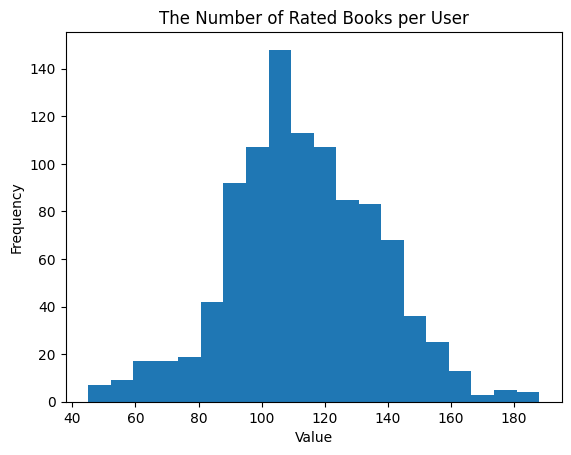

Mean: 113.518
Median: 112.0
Standard Deviation: 23.525638694836744


In [5]:
import matplotlib.pyplot as plt

data = ratings_subset.groupby('user_id')['book_id'].nunique()

# create a histogram with 20 bins
plt.hist(data, bins=20)

# add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('The Number of Rated Books per User')

# show the plot
plt.show()

# calculate the mean of the vector
mean = np.mean(data)

# calculate the median of the vector
median = np.median(data)

# calculate the standard deviation of the vector
std_dev = np.std(data)

# print the summary statistics
print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)

The Number of Genres

In [6]:
from itertools import chain

data = list(chain.from_iterable([x for x in match]))
unique_genres = set(data)
count_genres = len(unique_genres)

print(count_genres) 

633


10 most common genres

In [7]:
from collections import Counter

freq = Counter(data)
freq.most_common(10)

[('Fiction', 6247),
 ('Audiobook', 3128),
 ('Fantasy', 2719),
 ('Adult', 2195),
 ('Romance', 1952),
 ('Mystery', 1895),
 ('Young Adult', 1742),
 ('Classics', 1718),
 ('Contemporary', 1708),
 ('Novels', 1671)]

The Number of Ratings per Book

In [8]:
data = books_subset.books_count

# calculate the mean of the vector
mean = np.mean(data)

# calculate the median of the vector
median = np.median(data)

# calculate the standard deviation of the vector
std_dev = np.std(data)

# print the summary statistics
print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)

Mean: 86.33239540004894
Median: 46.0
Standard Deviation: 186.08779045128173


## Tranforming data

In [9]:
books_subset_g = books_subset.assign(genre=match)

In [10]:
import pandas as pd

# use the explode() function to convert the variable-length genre vector to a column of individual genres
df_exploded = books_subset_g.explode('genre')

# create a pivot table to convert the genre column into a set of binary indicator variables
df_exploded = df_exploded.groupby(['book_id', 'genre']).size().unstack(fill_value=0)
df_exploded = df_exploded.reset_index(drop = False)

item_train = pd.merge(books_subset.loc[:, ['book_id', 'average_rating', 'ratings_count']], df_exploded, on = 'book_id')
item_train = pd.merge(ratings_subset.book_id, item_train, on = 'book_id', how = 'left')

### user_train

In [11]:
import pandas as pd

# read in your data
df = pd.merge(ratings_subset, books_subset_g, on = 'book_id', how = 'left')

# explode the genre column into individual rows
df = df.explode('genre')

# group the data by user_id, genre, and book_id to get the average rating for each book within each user and genre
grouped = df.groupby(['user_id', 'genre', 'book_id'])['rating'].mean()

# reset the index to convert the multi-index into columns
grouped = grouped.reset_index()

# pivot the data to convert the unique genres into columns, with the values being the average rating for each user_id and genre combination
pivot = pd.pivot_table(grouped, values='rating', index='user_id', columns='genre', aggfunc='mean')

# reset the index to convert the user_id index into a column
user_train = pivot.reset_index()
user_train = pd.merge(ratings_subset.user_id, user_train, on = 'user_id', how = 'left')

### y_train

In [12]:
y_train = np.array(ratings_subset.rating)

### The format of input and output data

In [13]:
user_train.head(5)

,user_id,13th Century,14th Century,15th Century,16th Century,17th Century,18th Century,19th Century,1st Grade,20th Century,...,Young Adult Contemporary,Young Adult Fantasy,Young Adult Historical Fiction,Young Adult Paranormal,Young Adult Romance,Young Adult Science Fiction,Young Readers,Zen,Zimbabwe,Zombies
0,1,NaN,NaN,NaN,NaN,5.0,NaN,4.125,NaN,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,5.0,NaN,4.125,NaN,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NaN,NaN,NaN,NaN,5.0,NaN,4.125,NaN,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NaN,NaN,NaN,NaN,5.0,NaN,4.125,NaN,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,NaN,NaN,NaN,NaN,5.0,NaN,4.125,NaN,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
item_train.head(5)

,book_id,average_rating,ratings_count,13th Century,14th Century,15th Century,16th Century,17th Century,18th Century,19th Century,...,Young Adult Contemporary,Young Adult Fantasy,Young Adult Historical Fiction,Young Adult Paranormal,Young Adult Romance,Young Adult Science Fiction,Young Readers,Zen,Zimbabwe,Zombies
0,258,4.24,263685,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,140,4.20,443951,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,869,3.73,101669,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2679,3.56,35677,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1310,4.11,60126,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
y_train[:5]

array([5, 3, 4, 3, 4], dtype=int64)

## Model Development
I developed a DNN-based recommender system using Python and TensorFlow. The model consisted of multiple layers, including embedding layers for the book and user features, as well as fully connected layers.

In [16]:
# Replace missing values of user_train as 0
user_train.fillna(0, inplace=True)

In [17]:
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
pd.set_option("display.precision", 1)

In [18]:
num_user_features = user_train.shape[1] - 1
num_item_features = item_train.shape[1] - 1  
uvs = 1  # user genre vector start
ivs = 3  # item genre vector start
u_s = 1  # start of columns to use in training, user
i_s = 1 # start of columns to use in training, items
print(f"Number of training vectors: {len(item_train)}")

# scale training data
item_train_unscaled = item_train
user_train_unscaled = user_train
y_train_unscaled    = y_train

scalerItem = StandardScaler()
scalerItem.fit(item_train)
item_train = scalerItem.transform(item_train)

scalerUser = StandardScaler()
scalerUser.fit(user_train)
user_train = scalerUser.transform(user_train)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.reshape(-1, 1))

print(np.allclose(item_train_unscaled, scalerItem.inverse_transform(item_train)))
print(np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train)))

item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)

Number of training vectors: 113518
True
True


# Deep Neural Network for Content-Based filtering

In [19]:
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([   
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs),    
])

item_NN = tf.keras.models.Sequential([   
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs),   
])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 632)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 634)]        0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32)           199072      ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32)           199584      ['input_2[0][0]']                
                                                                                              

In [20]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)

In [21]:
tf.random.set_seed(1)
model.fit([user_train[:, u_s:], item_train[:, i_s:]], y_train, epochs=10)

Epoch 1/10
2838/2838 [==============================] - 10s 3ms/step - loss: 0.1987
Epoch 2/10
2838/2838 [==============================] - 9s 3ms/step - loss: 0.1899
Epoch 3/10
2838/2838 [==============================] - 9s 3ms/step - loss: 0.1861
Epoch 4/10
2838/2838 [==============================] - 10s 3ms/step - loss: 0.1815
Epoch 5/10
2838/2838 [==============================] - 9s 3ms/step - loss: 0.1775
Epoch 6/10
2838/2838 [==============================] - 9s 3ms/step - loss: 0.1742
Epoch 7/10
2838/2838 [==============================] - 11s 4ms/step - loss: 0.1714
Epoch 8/10
2838/2838 [==============================] - 10s 4ms/step - loss: 0.1694
Epoch 9/10
2838/2838 [==============================] - 10s 4ms/step - loss: 0.1675
Epoch 10/10
2838/2838 [==============================] - 10s 4ms/step - loss: 0.1659


## Model Evaluation

I evaluated the model using test dataset.

In [22]:
model.evaluate([user_test[:, u_s:], item_test[:, i_s:]], y_test)

710/710 [==============================] - 1s 2ms/step - loss: 0.1872


0.1871759593486786